In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from mamba import Mamba, MambaConfig
import argparse
import akshare as ak


贵州茅台（600519.SH）：消费行业龙头，市值高，交易活跃。\
平安银行（000001.SZ）：金融行业代表，市值高，交易活跃。\
中国平安（601318.SH）：保险行业龙头，市值高，交易活跃。\
恒瑞医药（600276.SH）：医药行业龙头，市值高，具有行业代表性。\
招商银行（600036.SH）：银行业龙头，市值高，交易活跃。\
万科A（000002.SZ）：房地产行业代表，市值高，交易活跃。\
五粮液（000858.SZ）：白酒行业龙头，市值高，交易活跃。\
海康威视（002415.SZ）：科技行业代表，市值高，交易活跃。

In [10]:
# 设置参数
class Args:
    use_cuda = True
    seed = 1
    epochs = 90
    lr = 0.01
    wd = 1e-5
    hidden = 16
    layer = 2
    n_test = 46
    ts_code = '301314'
    cfe = 'False'
    
args = Args()
args.cuda = args.use_cuda and torch.cuda.is_available()

In [11]:
if args.cfe == 'True':
    args.epochs += 50

def evaluation_metric(y_test,y_hat):
    MSE = mean_squared_error(y_test, y_hat)
    RMSE = MSE**0.5
    MAE = mean_absolute_error(y_test,y_hat)
    R2 = r2_score(y_test,y_hat)
    with open(f'Mamba/MTS_{stock_name}_evaluation.txt', 'w') as f:
        f.write(f"MSE: {MSE}\n")
        f.write(f"RMSE: {RMSE}\n")
        f.write(f"MAE: {MAE}\n")
        f.write(f"R2: {R2}\n")
    print('%.4f %.4f %.4f %.4f' % (MSE,RMSE,MAE,R2))

def set_seed(seed,cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed(seed)

def dateinf(series, n_test):
    lt = len(series)
    print('Training start',series[0])
    print('Training end',series[lt-n_test-1])
    print('Testing start',series[lt-n_test])
    print('Testing end',series[lt-1])

set_seed(args.seed,args.cuda)

class Net(nn.Module):
    def __init__(self,in_dim,out_dim):
        super().__init__()
        self.config = MambaConfig(d_model=args.hidden, n_layers=args.layer)
        self.mamba = nn.Sequential(
            nn.Linear(in_dim,args.hidden),
            Mamba(self.config),
            nn.Linear(args.hidden,out_dim),
            nn.Tanh()
        )
    
    def forward(self,x):
        x = self.mamba(x)
        return x.flatten()

def PredictWithData(trainX, trainy, testX):
    clf = Net(len(trainX[0]),1)
    opt = torch.optim.Adam(clf.parameters(),lr=args.lr,weight_decay=args.wd)
    xt = torch.from_numpy(trainX).float().unsqueeze(0)
    xv = torch.from_numpy(testX).float().unsqueeze(0)
    yt = torch.from_numpy(trainy).float()
    if args.cuda:
        clf = clf.cuda()
        xt = xt.cuda()
        xv = xv.cuda()
        yt = yt.cuda()
    
    for e in range(args.epochs):
        clf.train()
        z = clf(xt)
        loss = F.mse_loss(z,yt)
        opt.zero_grad()
        loss.backward()
        opt.step()
        if e%10 == 0 and e!=0:
            print('Epoch %d | Lossp: %.4f' % (e, loss.item()))

    clf.eval()
    mat = clf(xv)
    if args.cuda: mat = mat.cpu()
    yhat = mat.detach().numpy().flatten()
    return yhat


In [12]:
stock_code = args.ts_code
data = ak.stock_zh_a_hist(symbol=stock_code, period="daily", start_date="20230701", end_date="20240701", adjust="qfq")

data.rename(columns={
    "日期": "trade_date",
    "开盘": "open",
    "收盘": "close",
    "最高": "high",
    "最低": "low",
    "成交量": "volume",
    "成交额": "amount",
    "振幅": "amplitude",
    "涨跌幅": "pct_chg",
    "涨跌额": "change",
    "换手率": "turnover"
}, inplace=True)
# data['trade_date'] = pd.to_datetime(data['trade_date'], format='%Y-%m-%d')
data.set_index('trade_date', inplace=True) ## 作为索引值
close = data.pop('close').values
ratechg = data['pct_chg'].apply(lambda x: 0.01 * x).values
data.drop(columns=['open', 'high', 'low', 'volume', 'amount', 'amplitude', 'change', 'turnover'], inplace=True)
# data = data.apply(pd.to_numeric, errors='coerce')
dat = data.iloc[:, 1:].values
trainX, testX = dat[:-args.n_test, :], dat[-args.n_test:, :]
trainy = ratechg[:-args.n_test]
predictions = PredictWithData(trainX, trainy, testX)



Epoch 10 | Lossp: 0.0048
Epoch 20 | Lossp: 0.0027
Epoch 30 | Lossp: 0.0009
Epoch 40 | Lossp: 0.0003
Epoch 50 | Lossp: 0.0003
Epoch 60 | Lossp: 0.0002
Epoch 70 | Lossp: 0.0002
Epoch 80 | Lossp: 0.0002


In [13]:
stock_info = ak.stock_zh_a_spot_em()[ak.stock_zh_a_spot_em()['代码'] == stock_code]
stock_name = stock_info['名称'].values[0] if not stock_info.empty else "Unknown"

In [14]:
import matplotlib.dates as mdates

Index([2024-04-23, 2024-04-24, 2024-04-25, 2024-04-26, 2024-04-29, 2024-04-30,
       2024-05-06, 2024-05-07, 2024-05-08, 2024-05-09, 2024-05-10, 2024-05-13,
       2024-05-14, 2024-05-15, 2024-05-16, 2024-05-17, 2024-05-20, 2024-05-21,
       2024-05-22, 2024-05-23, 2024-05-24, 2024-05-27, 2024-05-28, 2024-05-29,
       2024-05-30, 2024-05-31, 2024-06-03, 2024-06-04, 2024-06-05, 2024-06-06,
       2024-06-07, 2024-06-11, 2024-06-12, 2024-06-13, 2024-06-14, 2024-06-17,
       2024-06-18, 2024-06-19, 2024-06-20, 2024-06-21, 2024-06-24, 2024-06-25,
       2024-06-26, 2024-06-27, 2024-06-28, 2024-07-01],
      dtype='object', name='trade_date')
46
46
46
MSE RMSE MAE R2
0.5416 0.7360 0.3964 0.9701


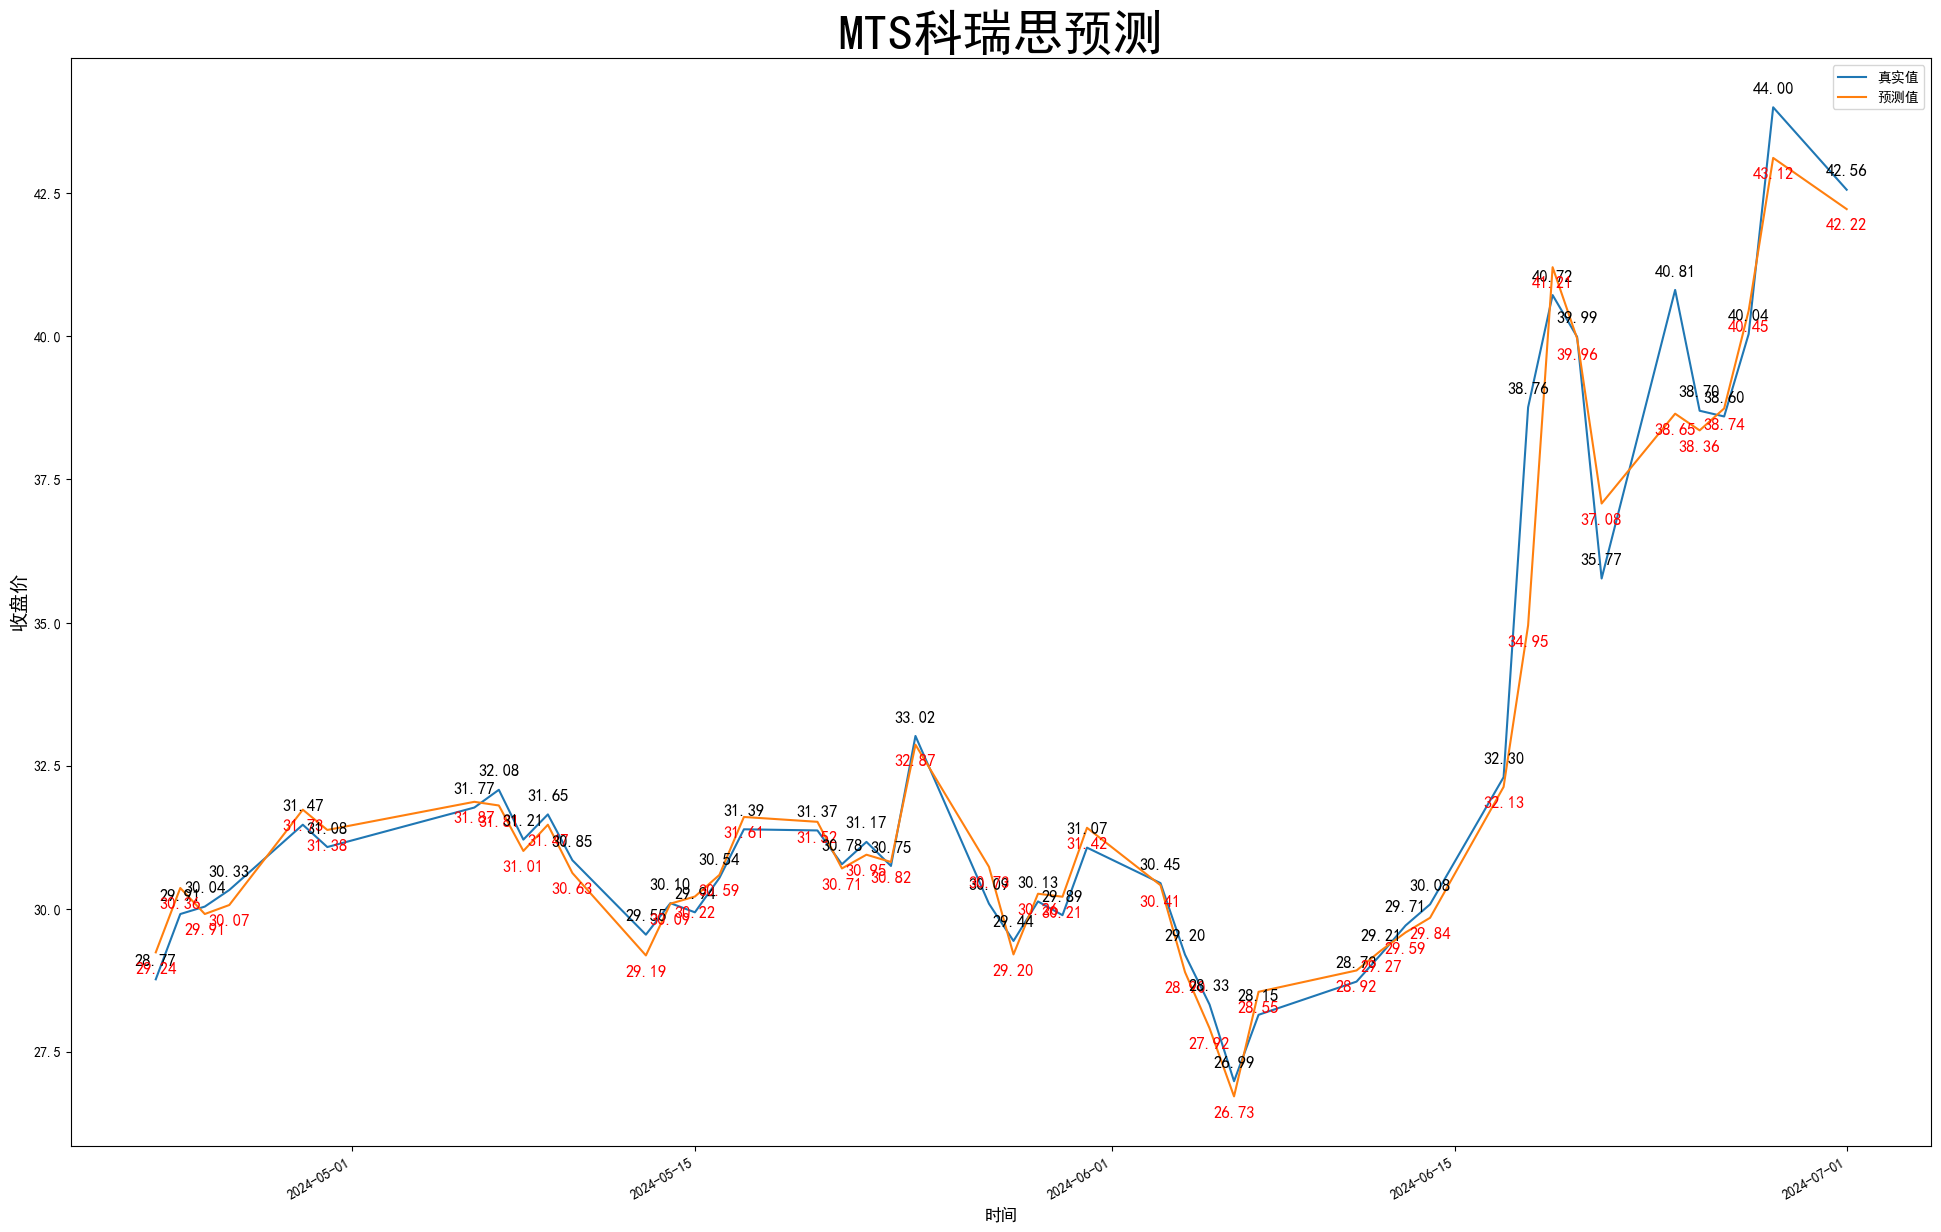

In [15]:
time = data.index[-args.n_test:]
print(time)
data1 = close[-args.n_test:]
finalpredicted_stock_price = []
pred = close[-args.n_test-1]
for i in range(args.n_test):
    pred = close[-args.n_test-1+i] * (1 + predictions[i])
    finalpredicted_stock_price.append(pred)
    
# data1 = data1[:len(data1) - 1]
# finalpredicted_stock_price = finalpredicted_stock_price[1:]
# time = time[1:]

print(len(data1))
print(len(finalpredicted_stock_price))
print(len(time))
print('MSE RMSE MAE R2')
evaluation_metric(data1, finalpredicted_stock_price)


plt.rcParams['font.sans-serif'] = ['SimHei']

plt.figure(figsize=(24, 16))
plt.plot(time, data1, label='真实值')
plt.plot(time, finalpredicted_stock_price, label='预测值')

for i in range(len(time)):
    plt.annotate(f'{data1[i]:.2f}', (time[i], data1[i]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=12)
    plt.annotate(f'{finalpredicted_stock_price[i]:.2f}', (time[i], finalpredicted_stock_price[i]), textcoords="offset points", xytext=(0, -15), ha='center', fontsize=12, color='red')

plt.title(f'MTS{stock_name}预测',fontsize=36)
plt.xlabel('时间', fontsize=12, verticalalignment='top')
plt.ylabel('收盘价', fontsize=14, horizontalalignment='center')
plt.gcf().autofmt_xdate()  # 自动旋转日期标签
plt.legend()
plt.savefig(f'Mamba/MTS{stock_name}.png', dpi=300, bbox_inches='tight')

plt.show()